In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import keras.layers as kl

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [ ]:
# building model

input_layer = kl.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)) # Input((img_width, img_height, img_channel))

s = kl.Lambda(lambda x: x/255)(input_layer) # converted input into floating

In [ ]:
# starting with contraction path first layer

conv1 = kl.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
# kernel_initializer: well you have to start with some weight, so entire deep learning is nothing but the neural network is trying to 
#                     update the weights AND where does it actually get the starting weights that's what this initializer basically means.
#                     So it needs some starting weights so iteratively it can update them to get these value better
#
#                     'he_normal' is one that function which uses normal( Gaussian ) distribution except it is a truncated normal distribution which is
#                     centered around zero.
conv1 = kl.Dropout(0.1)(conv1)
conv1 = kl.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
pool1 = kl.MaxPooling2D((2,2))(conv1)

The above cell done the following work

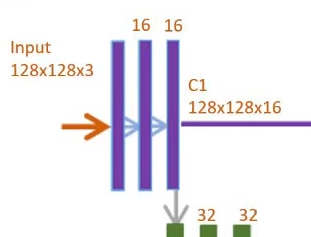

In [ ]:
# similarly adding other layers

conv2 = kl.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
conv2 = kl.Dropout(0.1)(conv2)
conv2 = kl.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
pool2 = kl.MaxPooling2D((2,2))(conv2)

conv3 = kl.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
conv3 = kl.Dropout(0.2)(conv3)
conv3 = kl.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
pool3 = kl.MaxPooling2D((2,2))(conv3)

conv4 = kl.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
conv4 = kl.Dropout(0.2)(conv4)
conv4 = kl.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
pool4 = kl.MaxPooling2D((2,2))(conv4)

conv5 = kl.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
conv5 = kl.Dropout(0.3)(conv5)
conv5 = kl.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
pool5 = kl.MaxPooling2D((2,2))(conv5)

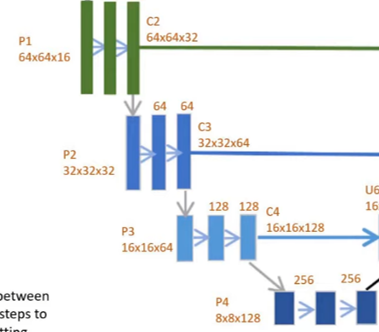

In [ ]:
# now doing expansion

upsl6 = kl.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv5)
upsl6 = kl.concatenate([upsl6, conv4])
conv6 = kl.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsl6)
conv6 = kl.Dropout(0.2)(conv6)
conv6 = kl.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

upsl7 = kl.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(conv6)
upsl7 = kl.concatenate([upsl7, conv3])
conv7 = kl.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsl7)
conv7 = kl.Dropout(0.2)(conv7)
conv7 = kl.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)

upsl8 = kl.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(conv7)
upsl8 = kl.concatenate([upsl8, conv2])
conv8 = kl.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsl8)
conv8 = kl.Dropout(0.1)(conv8)
conv8 = kl.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)

upsl9 = kl.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(conv8)
upsl9 = kl.concatenate([upsl9, conv1], axis=3)
conv9 = kl.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsl9)
conv9 = kl.Dropout(0.1)(conv9)
conv9 = kl.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)

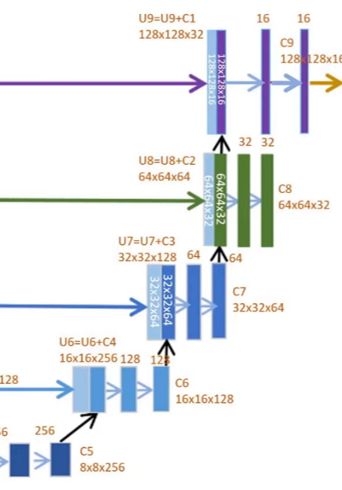

In [ ]:
# defining output layer

output_layer = kl.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

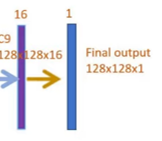

In [ ]:
model = tf.keras.Model(inputs = [input_layer], outputs = [output_layer])
model.compile(loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
from numpy.core.memmap import uint8
from tqdm import tqdm # tqdm shoes the progress bar during the loop execution
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import os

TRAIN_PATH = '/content/drive/MyDrive/Dataset/biology_nucleus/train/'
TEST_PATH = '/content/drive/MyDrive/Dataset/biology_nucleus/test'

train_ids = next(os.walk(TRAIN_PATH))[1] # next returns next item from the iterator AND [1] uses because without it creats tuple where the first entry is folder name and from second entry it has subfolder list
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('X_train summary : ', X_train.shape)
print('y_train summary : ', y_train.shape)

X_train summary :  (670, 128, 128, 3)
y_train summary :  (670, 128, 128, 1)


<ipython-input-21-852f4fd4ff6b>:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


In [ ]:
print('resizing images and masks')
for n, _id in tqdm(enumerate(train_ids), total=len(train_ids)):
  path = TRAIN_PATH + _id
  img = imread(path + '/images/' + _id + '.png')[:, :, :IMG_CHANNELS]
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_train[n] = img # fill empty X_train with values from img
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  for mask_file in next(os.walk(path + '/masks/'))[2]:
    _mask = imread(path + '/masks/' + mask_file)
    _mask = np.expand_dims(resize(_mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    mask = np.maximum(mask, _mask)
  
  y_train[n] = mask

resizing images and masks


  0%|          | 0/670 [00:00<?, ?it/s]<ipython-input-25-46038a8cfb5e>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████| 670/670 [1:34:43<00:00,  8.48s/it]


In [ ]:
# test images

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n, _id in tqdm(enumerate(test_ids), total=len(test_ids)):
  path = TEST_PATH + '/' + _id
  img = imread(path + '/images/' + _id + '.png')[:, :, :IMG_CHANNELS]
  sizes_test.append([img.shape[0], img.shape[1]])
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_test[n] = img # fill empty X_train with values from img

Resizing test images


100%|██████████| 65/65 [00:31<00:00,  2.06it/s]


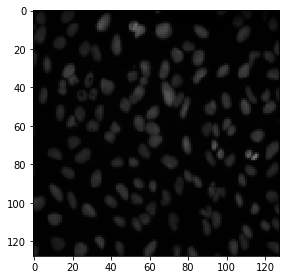

TypeError: ignored

In [ ]:
img_x = random.randint(0, len(train_ids))
imshow(X_train[img_x])
plt.show()
imshow(np.squeeze(y_train[img_x]))
plt.show()

In [ ]:
# model checkpoint

checkpointer = tf.keras.callbacks.Model('file_name', verbose=1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
    tf.keras.callbacks.TensirBoard(log_dir='logs')
    ]
result = model.fit(X_train, y_train, validation_split=0.1, epochs=15, batch_size=16, callbacks=callbacks)

In [ ]:
idx = random. randint(0, len(X_train))

# every picel has a probability value between 0 to 1
pred_train = model.predict(X_train[: int(X_train.shape[0]*0.9)], verbose=1) # training images
pred_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1) # validation images
pred_test = model.predict(X_test, verbose=1) # test images

# making above probability value in a binary term
pred_train_t = (pred_train > 0.5).astype(np.uint8)
pred_val_t = (pred_val > 0.5).astype(np.uint8)
pred_test_t = (pred_test > 0.5).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random. randint(0, len(pred_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(pred_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random. randint(0, len (pred_val_t))
imshow(X_train[int (X_train.shape[0]*0.9):][ix])
plt. show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt. show()
imshow(np.squeeze(pred_val_t[ix]))
plt.show()